In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.signal as signal
import torch.distributions as dist
from jaxtyping import Float, Int
from torch import Tensor
import spikeinterface.extractors as se
import spikeinterface.comparison as sc
from spikeinterface.preprocessing import bandpass_filter
from sklearn.metrics import confusion_matrix, adjusted_rand_score
from scipy.signal import find_peaks
import h5py

In [3]:
def load_mearec_data(recording_file="recordings.h5"):
    """
    Load MEArec data and convert to PyTorch tensors compatible with the notebook format
    """
    # Load MEArec data
    recording, sorting_true = se.read_mearec(recording_file)
    
    # Apply preprocessing (bandpass filter)
    recording_filt = bandpass_filter(recording, freq_min=300, freq_max=6000)
    
    # Get traces as numpy array and convert to torch tensor
    traces = torch.tensor(recording_filt.get_traces(), dtype=torch.float32)
    
    # Get ground truth spike times and IDs
    true_spike_times = []
    true_spike_ids = []
    
    for unit_id in sorting_true.unit_ids:
        unit_spikes = sorting_true.get_unit_spike_train(unit_id)
        true_spike_times.extend(unit_spikes)
        # Convert unit_id to integer (remove '#' if present)
        unit_idx = int(unit_id.lstrip('#')) if isinstance(unit_id, str) else int(unit_id)
        true_spike_ids.extend([unit_idx] * len(unit_spikes))
    
    # Sort by spike times
    sorted_indices = np.argsort(true_spike_times)
    true_spike_times = torch.tensor([true_spike_times[i] for i in sorted_indices], dtype=torch.long)
    true_spike_ids = torch.tensor([true_spike_ids[i] for i in sorted_indices], dtype=torch.long)
    
    # Extract true templates from MEArec data
    with h5py.File(recording_file, 'r') as f:
        templates = f['templates'][:]  # Shape: (n_units, n_jitters, n_channels, n_samples)
        
    # Convert templates to the expected format: (n_units, n_samples, n_channels)
    # Take median across jitters and transpose
    true_templates = torch.tensor(np.median(templates, axis=1).transpose(0, 2, 1), dtype=torch.float32)
    
    # Constants
    sampling_frequency = recording.sampling_frequency
    num_samples, num_channels = traces.shape
    true_num_spikes = len(true_spike_times)
    true_num_neurons, window_size, _ = true_templates.shape
    
    return {
        'traces': traces,
        'true_spike_times': true_spike_times,
        'true_spike_ids': true_spike_ids,
        'true_templates': true_templates,
        'sampling_frequency': sampling_frequency,
        'num_samples': num_samples,
        'num_channels': num_channels,
        'true_num_spikes': true_num_spikes,
        'true_num_neurons': true_num_neurons,
        'window_size': window_size
    }

In [22]:
data = load_mearec_data("data/sim_data/recordings3.h5")

# Extract variables in the same format as the original notebook
traces = data['traces']
true_spike_times = data['true_spike_times']
true_spike_ids = data['true_spike_ids']
true_templates = data['true_templates']

SAMPLING_FREQUENCY = data['sampling_frequency']
NUM_SAMPLES, NUM_CHANNELS = traces.shape
TRUE_NUM_SPIKES = data['true_num_spikes']
TRUE_NUM_NEURONS, WINDOW_SIZE, _ = true_templates.shape
WINDOW_SIZE = 96

print(f"✅ Loaded MEArec data:")
print(f"   Traces shape: {traces.shape}")
print(f"   True spikes: {TRUE_NUM_SPIKES}")
print(f"   True neurons: {TRUE_NUM_NEURONS}")
print(f"   Sampling frequency: {SAMPLING_FREQUENCY} Hz")
print(f"   Window size: {WINDOW_SIZE}")

✅ Loaded MEArec data:
   Traces shape: torch.Size([320000, 32])
   True spikes: 818
   True neurons: 8
   Sampling frequency: 32000.0 Hz
   Window size: 96


In [5]:
def plot_slice(traces: Float[Tensor, "num_samples num_channels"],
               spike_times: Int[Tensor, "num_spikes"],
               spike_ids: Int[Tensor, "num_spikes"],
               start_time: float=0,
               end_time: float=1.0,
               ylim: float=None):
    """
    Plot a slice of the recording and the corresponding spike times.
    """
    # Extract constants
    num_samples, num_channels = traces.shape
    num_neurons = spike_ids.max() + 1
    
    # Extract the slice of the recording
    slc = slice(int(start_time * SAMPLING_FREQUENCY), int(end_time * SAMPLING_FREQUENCY))
    
    # Get the y-limit for traces if not specified
    if ylim is None:
        ylim = 1.05 * traces[slc].abs().max()
    
    # Make an array of times in seconds
    times_sec = torch.arange(0, num_samples) / SAMPLING_FREQUENCY
    spike_times_sec = times_sec[spike_times]
    spike_in_slice = (spike_times_sec >= start_time) & (spike_times_sec <= end_time)
    
    # Plot the spike raster
    fig, axs = plt.subplots(num_channels + 1, 1, sharex=True, figsize=(6, 1.5 * (num_channels + 1)))
    
    axs[0].plot(spike_times_sec[spike_in_slice], spike_ids[spike_in_slice], '|k', markersize=6)
    axs[0].set_ylabel("neuron")
    axs[0].set_yticks(torch.arange(0, num_neurons))
    axs[0].set_title("spike train")
    
    # Plot the voltage traces
    for i in range(num_channels):
        axs[i+1].plot(times_sec[slc], traces[slc, i], color='k', lw=1, alpha=0.5)
        axs[i+1].set_title(f"channel {i+1}", fontsize=10)
        axs[i+1].set_ylim(-ylim, ylim)
        axs[i+1].set_ylabel("trace\n[z-score]")
        axs[i+1].set_xlim(start_time, end_time)
        if i == num_channels - 1:
            axs[i+1].set_xlabel(f"time [sec]")
    
    plt.tight_layout()
    return fig, axs

In [6]:
def plot_waveforms(waveforms: Float[Tensor, "num_waveforms windows_size num_channels"],
                   name: str="waveform"):
    """
    Plot a grid of spike waveforms or templates.
    """
    num_waveforms, window_size, num_channels = waveforms.shape
    times = torch.arange(-window_size//2, window_size//2) / SAMPLING_FREQUENCY * 1000
    
    fig, axs = plt.subplots(num_channels, num_waveforms,
                           figsize=(1.25 * num_waveforms, 1.25 * num_channels),
                           sharex=True, sharey=True)
    
    # Handle case where there's only one channel or one waveform
    if num_channels == 1:
        axs = axs.reshape(1, -1)
    if num_waveforms == 1:
        axs = axs.reshape(-1, 1)
    
    lim = 1.05 * waveforms.abs().max()
    
    for j in range(num_waveforms):
        for i in range(num_channels):
            axs[i,j].plot(times, waveforms[j,:,i], color='k', lw=1, alpha=0.5)
            axs[i,j].set_ylim(-lim, lim)
            
            if j == 0:
                axs[i,j].set_ylabel(f"channel {i}\n [z-score]")
            if i == 0:
                axs[i,j].set_title(f"{name} {j}")
            if i == num_channels - 1:
                axs[i,j].set_xlabel(f"time [ms]")
    
    plt.tight_layout()
    return fig, axs

In [7]:
def evaluate_detected_spikes(
    detected_spike_times: Int[Tensor, "num_detected_spikes"],
    true_spike_times: Int[Tensor, "num_true_spikes"]) -> dict:
    """
    Evaluate detected spikes against ground truth with boundary handling
    """
    num_windows = NUM_SAMPLES // WINDOW_SIZE
    
    # Filter out spikes that would cause out-of-bounds errors
    # Keep only spikes that fall within valid window boundaries
    valid_true_spikes = true_spike_times[true_spike_times < num_windows * WINDOW_SIZE]
    valid_detected_spikes = detected_spike_times[detected_spike_times < num_windows * WINDOW_SIZE]
    
    # Create masks for windows containing spikes
    true_spike_mask = torch.zeros(num_windows, dtype=torch.bool)
    if len(valid_true_spikes) > 0:
        true_spike_mask[valid_true_spikes // WINDOW_SIZE] = True
    
    detected_spike_mask = torch.zeros(num_windows, dtype=torch.bool)
    if len(valid_detected_spikes) > 0:
        detected_spike_mask[valid_detected_spikes // WINDOW_SIZE] = True
    
    # Calculate confusion matrix elements
    tp = (true_spike_mask & detected_spike_mask).sum().item()
    fp = (detected_spike_mask & ~true_spike_mask).sum().item()
    fn = (~detected_spike_mask & true_spike_mask).sum().item()
    tn = (~detected_spike_mask & ~true_spike_mask).sum().item()
    
    return dict(tp=tp, fp=fp, fn=fn, tn=tn)

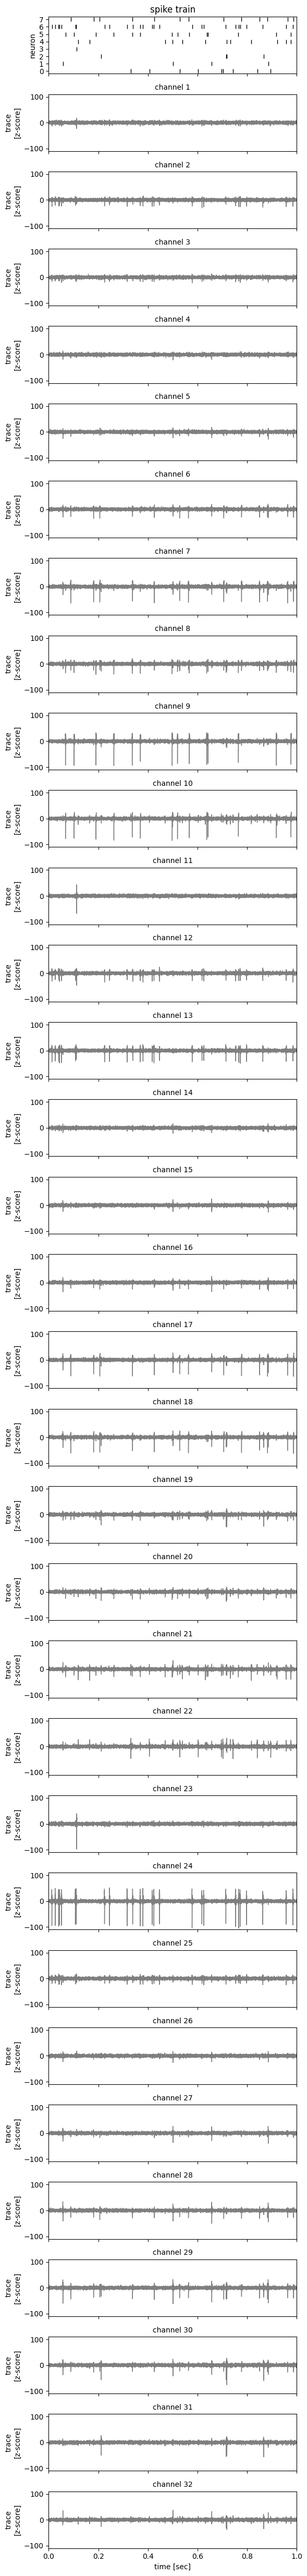

In [23]:
# Plot the first second of MEArec data
_ = plot_slice(traces, true_spike_times, true_spike_ids, start_time=0.0, end_time=1.0)

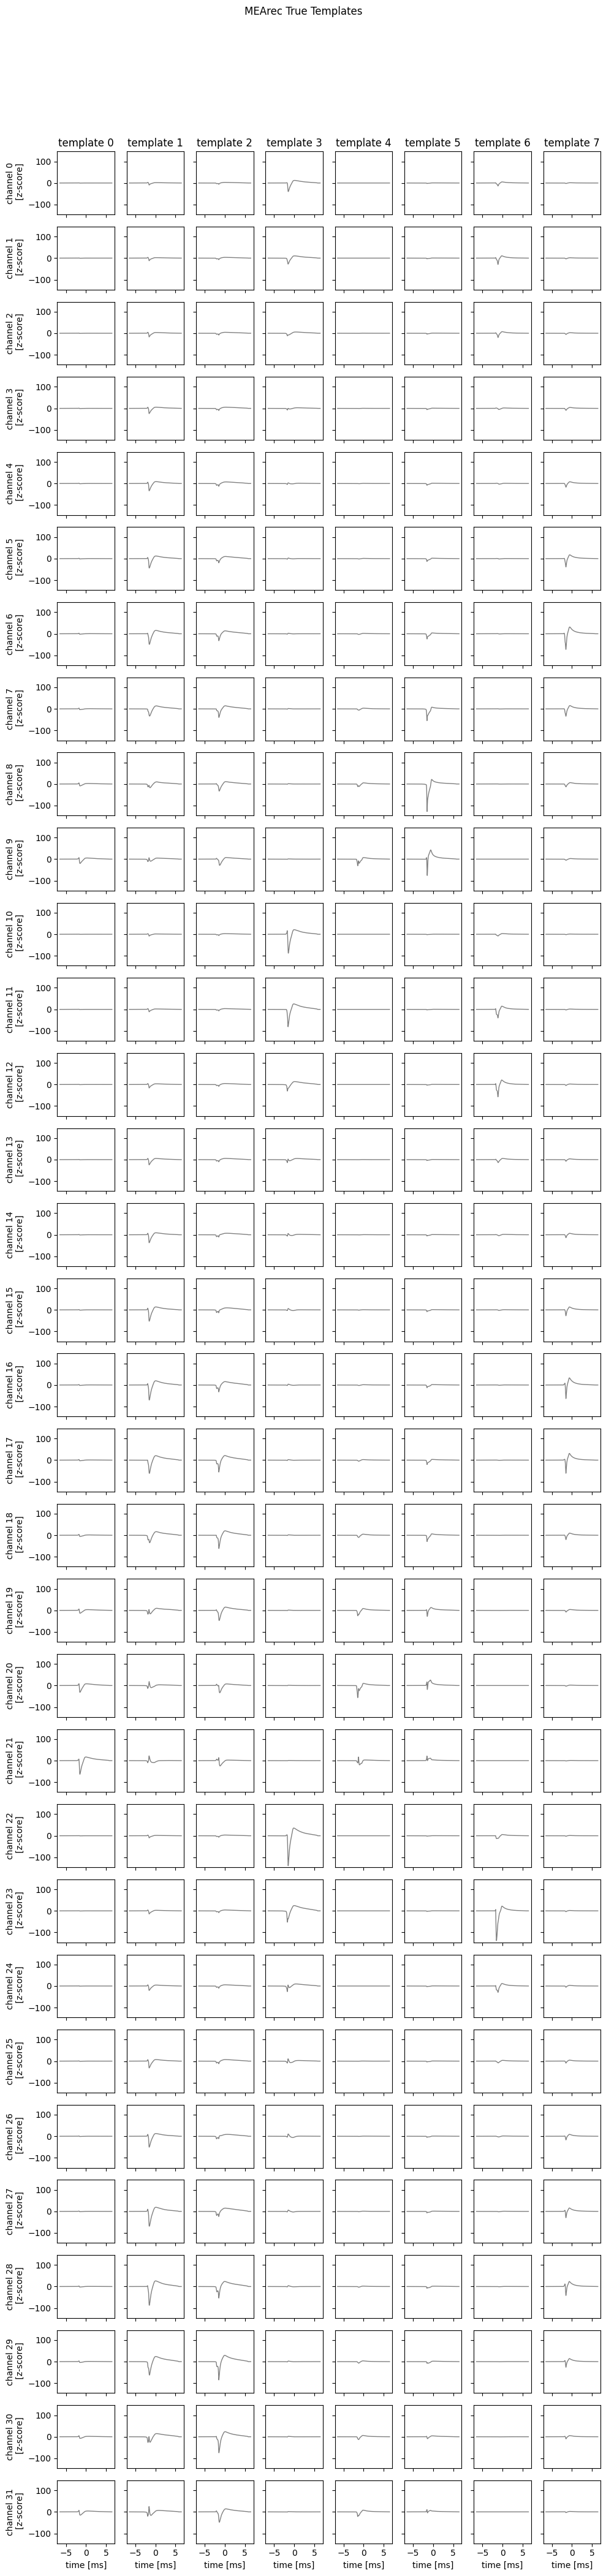

In [24]:
# Plot true templates
fig, axs = plot_waveforms(true_templates, name="template")
fig.suptitle("MEArec True Templates", y=1.05)
plt.show()

In [29]:
import spikeinterface.sorters as ss
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

# Use SpikeInterface's peak detection
print("🔧 Using SpikeInterface peak detection...")

# Convert back to SpikeInterface format temporarily
recording_si = se.read_mearec("data/sim_data/recordings3.h5")[0]
recording_filt = bandpass_filter(recording_si, freq_min=300, freq_max=6000)

# Detect peaks using SpikeInterface
peaks = detect_peaks(recording_filt, 
                    method='locally_exclusive',
                    peak_sign='neg',
                    detect_threshold=5.0,
                    exclude_sweep_ms=1.0)

# Convert back to torch tensors
si_spike_times = torch.tensor(peaks['sample_index'])
print(f"✅ SpikeInterface detected {len(si_spike_times)} spikes")

# Extract waveforms using SpikeInterface detection
#spike_waveforms_si = torch.zeros((len(si_spike_times), WINDOW_SIZE, NUM_CHANNELS))
traces_np = recording_filt.get_traces()

# for i, t in enumerate(si_spike_times):
#     start_idx = t - WINDOW_SIZE // 2
#     end_idx = t + WINDOW_SIZE // 2
    
#     if start_idx >= 0 and end_idx < traces_np.shape[0]:
#         spike_waveforms_si[i] = torch.tensor(traces_np[start_idx:end_idx])





🔧 Using SpikeInterface peak detection...


noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

detect peaks using locally_exclusive (no parallelization):   0%|          | 0/10 [00:00<?, ?it/s]

✅ SpikeInterface detected 813 spikes


Extracting waveforms with window size 96...
✅ Extracted 813 valid waveforms


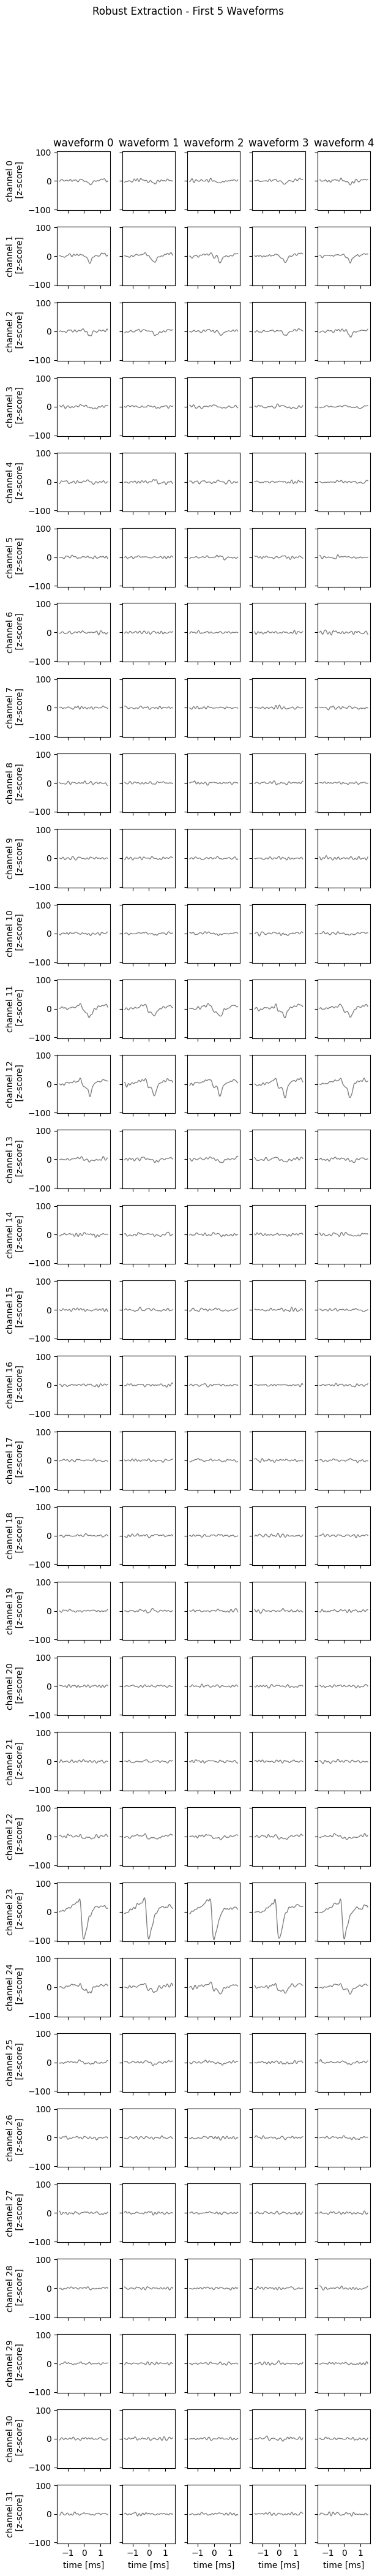

In [30]:
def extract_waveforms_robust(traces_np, spike_times, window_size):
    """
    Robust waveform extraction with proper boundary handling
    """
    num_spikes = len(spike_times)
    num_samples, num_channels = traces_np.shape
    half_window = window_size // 2
    
    spike_waveforms = []
    valid_spike_times = []
    
    print(f"Extracting waveforms with window size {window_size}...")
    
    for i, t in enumerate(spike_times):
        start_idx = int(t - half_window)
        end_idx = int(t + half_window)
        
        # Check boundaries
        if start_idx >= 0 and end_idx < num_samples:
            waveform = traces_np[start_idx:end_idx, :]
            
            # Verify we got the right shape
            if waveform.shape[0] == window_size:
                spike_waveforms.append(torch.tensor(waveform))
                valid_spike_times.append(t)
            else:
                print(f"Skipping spike {i}: wrong shape {waveform.shape}")
        else:
            print(f"Skipping spike {i}: out of bounds (start={start_idx}, end={end_idx})")
    
    if len(spike_waveforms) > 0:
        spike_waveforms = torch.stack(spike_waveforms)
        print(f"✅ Extracted {len(spike_waveforms)} valid waveforms")
    else:
        print("❌ No valid waveforms extracted!")
        spike_waveforms = torch.zeros((0, window_size, num_channels))
    
    return spike_waveforms, torch.tensor(valid_spike_times)


# Apply robust extraction
spike_waveforms_fixed, valid_spike_times = extract_waveforms_robust(
    traces_np, si_spike_times, WINDOW_SIZE
)

# Plot the results
if len(spike_waveforms_fixed) > 0:
    fig, axs = plot_waveforms(spike_waveforms_fixed[:5], name="waveform")
    fig.suptitle("Robust Extraction - First 5 Waveforms", y=1.05)
    plt.show()
else:
    print("No waveforms to plot!")

In [31]:
# Set fallback before any imports
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import torch

# Your existing transformer code will now work with MPS
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device} with MPS fallback enabled")


Using device: mps with MPS fallback enabled


Running Transformer-GMM Spike Sorting...
Using device: mps

TRANSFORMER-GMM SPIKE SORTING INTEGRATION
Novel approach: Multi-scale Transformer embeddings + GMM clustering
- Multi-scale patch embedding for temporal patterns
- Channel-wise attention for spatial correlations
- Contrastive learning for discriminative embeddings
- GMM clustering on learned representations

Scale dimensions: [86, 85, 85], sum: 256
TRANSFORMER-GMM SPIKE SORTING PIPELINE
Processing 813 spikes (96 samples x 32 channels)
Training Transformer with contrastive learning...


Training epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/50, Loss: 0.0956
Epoch 20/50, Loss: 0.0631
Epoch 30/50, Loss: 0.0515
Epoch 40/50, Loss: 0.0490
Epoch 50/50, Loss: 0.0480
Extracting embeddings...


Extracting embeddings:   0%|          | 0/13 [00:00<?, ?it/s]

Using ground truth: 8 clusters
Fitting GMM with 8 components...

Transformer-GMM Clustering Complete!
Clusters found: 8
Silhouette score: 0.035
Embedding dimension: 256

Transformer-GMM Results:
Clusters found: 8
Template shape: torch.Size([8, 96, 32])
Silhouette score: 0.035


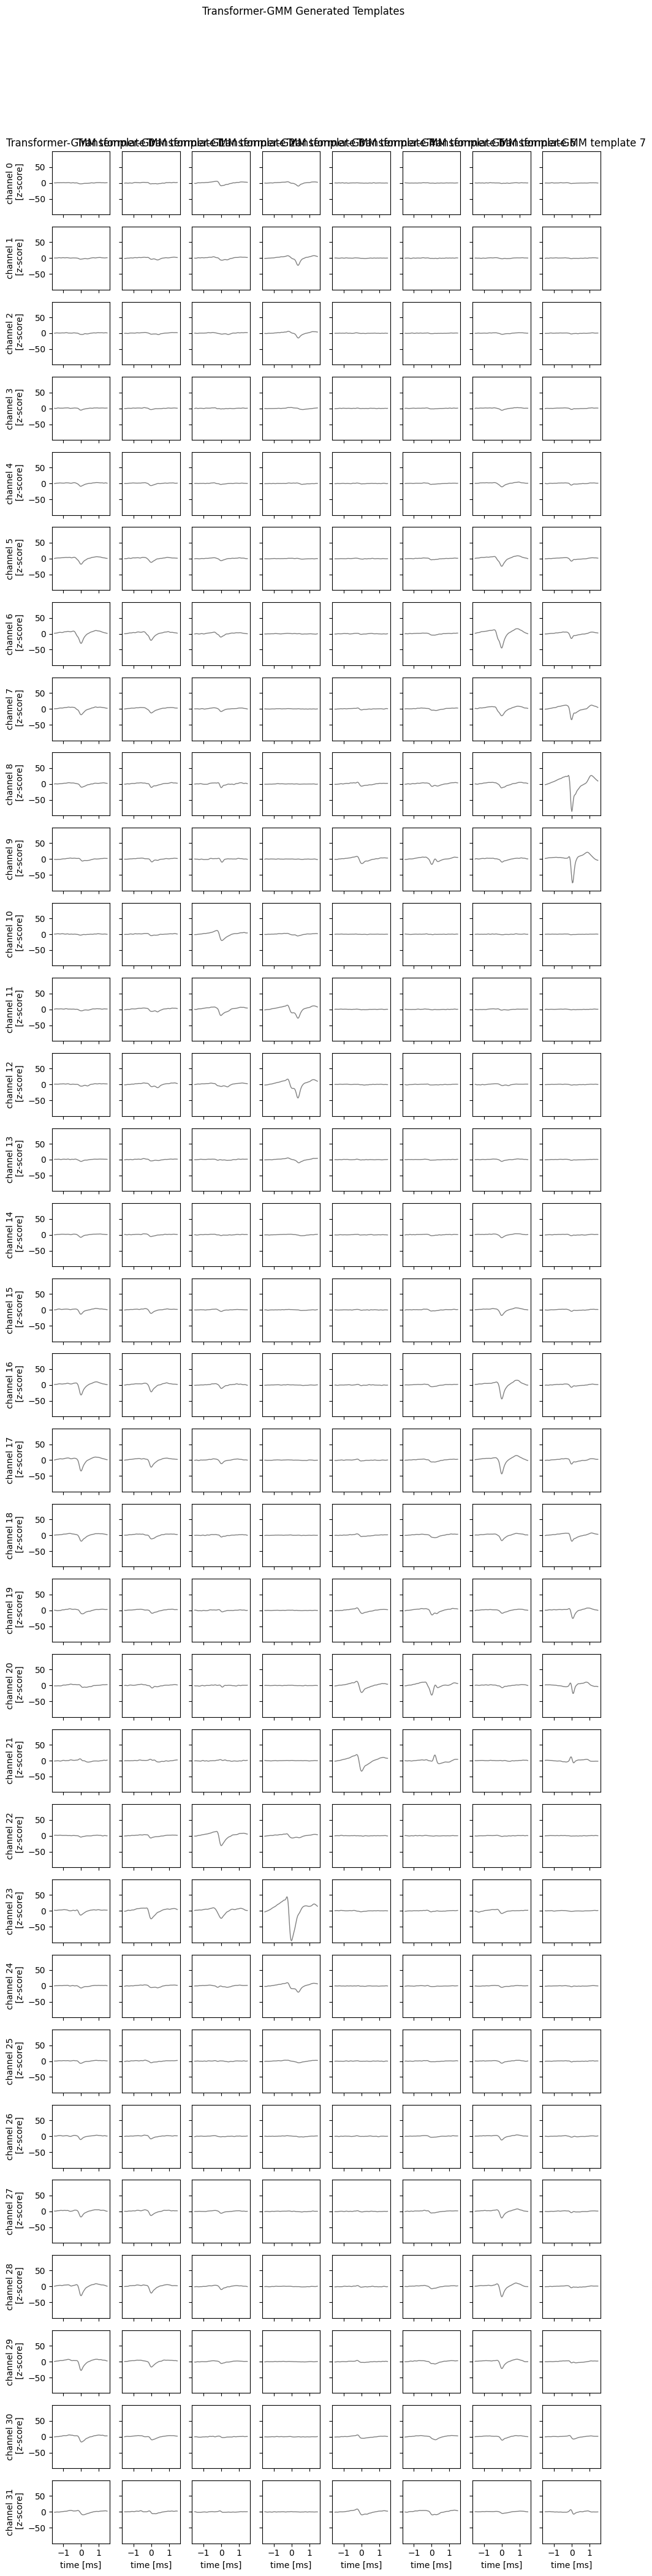

Evaluating Transformer-GMM clustering...


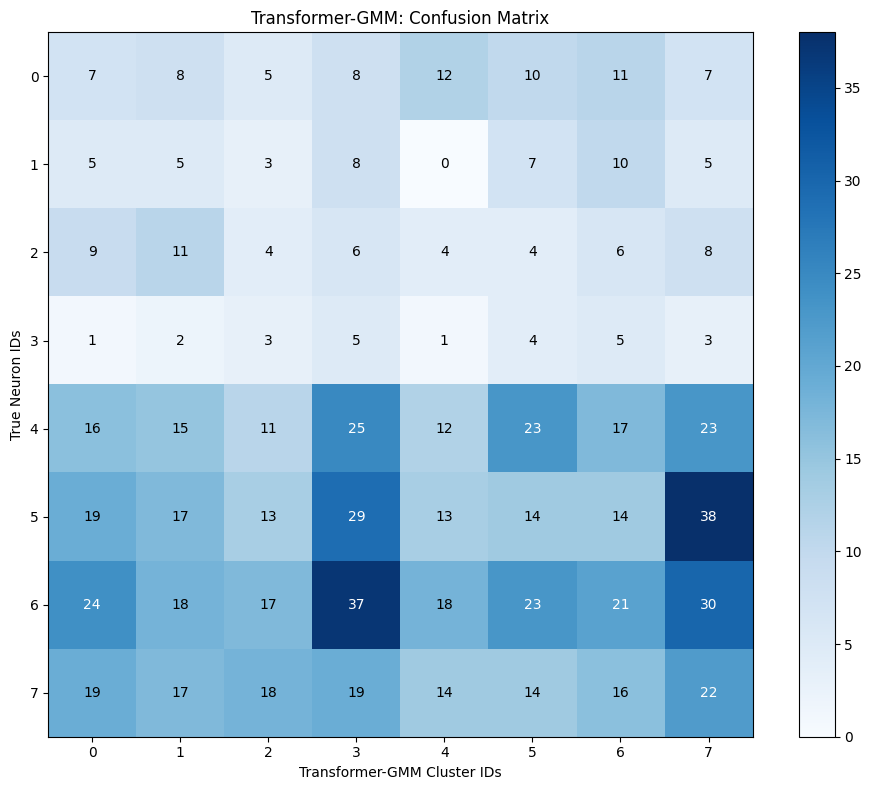


Transformer-GMM Performance:
Adjusted Rand Index: 0.001
Silhouette Score: 0.035
Number of clusters: 8


In [32]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math

class MultiChannelSpikeTransformer(nn.Module):
    def __init__(self, n_channels=32, window_size=96, d_model=256, n_heads=8, 
                 n_layers=4, patch_sizes=[8, 16, 24], dropout=0.1):
        super().__init__()
        self.n_channels = n_channels
        self.window_size = window_size
        self.d_model = d_model
        self.patch_sizes = patch_sizes
        self.n_scales = len(patch_sizes)
        
        # Calculate target number of patches
        self.target_patches = window_size // min(patch_sizes)
        
        # FIX: Ensure dimensions add up to d_model exactly
        base_dim = d_model // self.n_scales  # 85 for 3 scales
        remainder = d_model % self.n_scales   # 1 for 256 % 3
        
        # Distribute dimensions: [86, 85, 85] to sum to 256
        scale_dims = [base_dim + (1 if i < remainder else 0) for i in range(self.n_scales)]
        
        print(f"Scale dimensions: {scale_dims}, sum: {sum(scale_dims)}")
        
        # Multi-scale patch embeddings with exact dimension allocation
        self.patch_embedders = nn.ModuleList([
            nn.Conv1d(n_channels, scale_dims[i], kernel_size=p, stride=p)
            for i, p in enumerate(patch_sizes)
        ])
        
        # Channel embeddings for spatial awareness
        self.channel_embeddings = nn.Embedding(n_channels, d_model)
        
        # Positional encodings for temporal structure
        self.pos_encoder = PositionalEncoding(d_model, dropout, max_len=self.target_patches)
        
        # Temporal Transformer encoder
        temporal_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_model*4,
            dropout=dropout, activation='gelu', batch_first=True
        )
        self.temporal_encoder = nn.TransformerEncoder(temporal_layer, num_layers=n_layers)
        
        # Global pooling for spike-level embeddings
        self.global_pool = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Final embedding projection
        self.embedding_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model)
        )
        
    def forward(self, x):
        """
        Forward pass for spike embedding generation
        Args:
            x: (batch_size, window_size, n_channels)
        Returns:
            embeddings: (batch_size, embedding_dim)
        """
        batch_size = x.size(0)
        
        # Step 1: Multi-scale patch embedding with exact dimensions
        x_patches = []
        x_transposed = x.transpose(1, 2)  # (batch, channels, time)
        
        for embedder in self.patch_embedders:
            patches = embedder(x_transposed)  # (batch, scale_dim, n_patches)
            
            # Use interpolation for consistent patch count
            if patches.size(2) != self.target_patches:
                patches = torch.nn.functional.interpolate(
                    patches, size=self.target_patches, mode='linear', align_corners=False
                )
            
            patches = patches.transpose(1, 2)  # (batch, target_patches, scale_dim)
            x_patches.append(patches)
        
        # Concatenate multi-scale features (now sums to exactly d_model)
        x_embedded = torch.cat(x_patches, dim=-1)  # (batch, target_patches, d_model)
        
        # Verify dimension match
        assert x_embedded.size(-1) == self.d_model, f"Embedding dim {x_embedded.size(-1)} != d_model {self.d_model}"
        
        # Step 2: Add positional encoding
        x_embedded = self.pos_encoder(x_embedded)
        
        # Step 3: Temporal encoding
        x_temporal = self.temporal_encoder(x_embedded)
        
        # Step 4: Global pooling with CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x_with_cls = torch.cat([cls_tokens, x_temporal], dim=1)
        
        attn_output, _ = self.global_pool(cls_tokens, x_with_cls, x_with_cls)
        spike_embedding = attn_output.squeeze(1)  # (batch, d_model)
        
        # Step 5: Final embedding projection
        final_embedding = self.embedding_head(spike_embedding)
        
        return final_embedding



class PositionalEncoding(nn.Module):
    """Positional encoding for transformer"""
    
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(1), :].transpose(0, 1)
        return self.dropout(x)

class TransformerGMMSpikeSorter:
    """
    Complete Transformer-GMM pipeline for spike sorting
    """
    
    def __init__(self, n_channels=32, window_size=96, d_model=256, n_heads=8, 
                 n_layers=4, patch_sizes=[8, 16, 24], device='cpu'):
        self.device = device
        self.transformer = MultiChannelSpikeTransformer(
            n_channels=n_channels, window_size=window_size, d_model=d_model,
            n_heads=n_heads, n_layers=n_layers, patch_sizes=patch_sizes
        ).to(device)
        self.scaler = StandardScaler()
        self.gmm = None
        self.embeddings = None
        self.cluster_labels = None
        self.templates = None
        
    def _train_transformer(self, spike_waveforms, n_epochs=50, batch_size=64, lr=1e-4):
        """
        Train transformer using contrastive learning for better embeddings
        """
        print("Training Transformer with contrastive learning...")
        
        # Create data loader
        dataset = torch.utils.data.TensorDataset(spike_waveforms)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        # Optimizer and loss
        optimizer = torch.optim.AdamW(self.transformer.parameters(), lr=lr, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
        
        self.transformer.train()
        for epoch in tqdm(range(n_epochs), desc="Training epochs"):
            epoch_loss = 0
            for batch_idx, (batch_spikes,) in enumerate(dataloader):
                batch_spikes = batch_spikes.to(self.device)
                
                # Generate embeddings
                embeddings = self.transformer(batch_spikes)
                
                # Simple contrastive loss (InfoNCE-style)
                # Create positive pairs by adding noise
                noise = torch.randn_like(batch_spikes) * 0.1
                augmented_spikes = batch_spikes + noise
                augmented_embeddings = self.transformer(augmented_spikes)
                
                # Contrastive loss
                loss = self._contrastive_loss(embeddings, augmented_embeddings, temperature=0.1)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
            
            scheduler.step()
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(dataloader):.4f}")
    
    def _contrastive_loss(self, z1, z2, temperature=0.1):
        """Simple contrastive loss for self-supervised learning"""
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)
        
        batch_size = z1.size(0)
        sim_matrix = torch.mm(z1, z2.t()) / temperature
        
        # Positive pairs are on the diagonal
        labels = torch.arange(batch_size).to(self.device)
        loss = F.cross_entropy(sim_matrix, labels)
        
        return loss
    
    def _extract_embeddings(self, spike_waveforms, batch_size=64):
        """Extract embeddings from trained transformer"""
        print("Extracting embeddings...")
        
        self.transformer.eval()
        all_embeddings = []
        
        dataset = torch.utils.data.TensorDataset(spike_waveforms)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        with torch.no_grad():
            for batch_spikes, in tqdm(dataloader, desc="Extracting embeddings"):
                batch_spikes = batch_spikes.to(self.device)
                embeddings = self.transformer(batch_spikes)
                all_embeddings.append(embeddings.cpu())
        
        return torch.cat(all_embeddings, dim=0)
    
    def _estimate_clusters_gmm(self, embeddings, max_clusters=20):
        """Estimate optimal number of clusters using GMM with multiple criteria"""
        print("Estimating optimal number of clusters...")
        
        embeddings_np = embeddings.numpy()
        n_samples = len(embeddings_np)
        max_clusters = min(max_clusters, n_samples // 10)
        
        bic_scores = []
        aic_scores = []
        silhouette_scores = []
        cluster_range = range(2, max_clusters + 1)
        
        for n_components in tqdm(cluster_range, desc="Testing cluster counts"):
            gmm = GaussianMixture(
                n_components=n_components,
                covariance_type='full',
                random_state=42,
                max_iter=100
            )
            
            try:
                gmm.fit(embeddings_np)
                labels = gmm.predict(embeddings_np)
                
                bic_scores.append(gmm.bic(embeddings_np))
                aic_scores.append(gmm.aic(embeddings_np))
                
                if len(np.unique(labels)) > 1:
                    sil_score = silhouette_score(embeddings_np, labels)
                    silhouette_scores.append(sil_score)
                else:
                    silhouette_scores.append(-1)
                    
            except Exception as e:
                print(f"Failed for {n_components} components: {e}")
                bic_scores.append(float('inf'))
                aic_scores.append(float('inf'))
                silhouette_scores.append(-1)
        
        # Select optimal using silhouette score
        optimal_idx = np.argmax(silhouette_scores)
        optimal_clusters = cluster_range[optimal_idx]
        
        print(f"Optimal clusters: {optimal_clusters}")
        print(f"Best silhouette score: {silhouette_scores[optimal_idx]:.3f}")
        
        return optimal_clusters, silhouette_scores[optimal_idx]
    
    def fit(self, spike_waveforms, true_num_neurons=None, train_transformer=True):
        """
        Complete Transformer-GMM fitting pipeline
        """
        print("TRANSFORMER-GMM SPIKE SORTING PIPELINE")
        print("=" * 60)
        
        # Convert to torch tensor and move to device
        if not torch.is_tensor(spike_waveforms):
            spike_waveforms = torch.tensor(spike_waveforms, dtype=torch.float32)
        spike_waveforms = spike_waveforms.to(self.device)
        
        n_spikes, window_size, n_channels = spike_waveforms.shape
        print(f"Processing {n_spikes} spikes ({window_size} samples x {n_channels} channels)")
        
        # Step 1: Train transformer (optional)
        if train_transformer:
            self._train_transformer(spike_waveforms)
        
        # Step 2: Extract embeddings
        self.embeddings = self._extract_embeddings(spike_waveforms)
        
        # Step 3: Standardize embeddings
        embeddings_scaled = self.scaler.fit_transform(self.embeddings.numpy())
        
        # Step 4: Estimate clusters or use ground truth
        if true_num_neurons is not None:
            n_clusters = true_num_neurons
            silhouette_score_final = None
            print(f"Using ground truth: {n_clusters} clusters")
        else:
            n_clusters, silhouette_score_final = self._estimate_clusters_gmm(
                torch.tensor(embeddings_scaled)
            )
        
        # Step 5: Fit final GMM
        print(f"Fitting GMM with {n_clusters} components...")
        self.gmm = GaussianMixture(
            n_components=n_clusters,
            covariance_type='full',
            random_state=42,
            max_iter=200
        )
        
        self.gmm.fit(embeddings_scaled)
        self.cluster_labels = self.gmm.predict(embeddings_scaled)
        
        # Calculate silhouette score if not already computed
        if silhouette_score_final is None:
            silhouette_score_final = silhouette_score(embeddings_scaled, self.cluster_labels)
        
        # Step 6: Generate templates
        self.templates = self._generate_templates(spike_waveforms.cpu(), self.cluster_labels, n_clusters)
        
        print(f"\nTransformer-GMM Clustering Complete!")
        print(f"Clusters found: {n_clusters}")
        print(f"Silhouette score: {silhouette_score_final:.3f}")
        print(f"Embedding dimension: {self.embeddings.shape[1]}")
        
        return {
            'cluster_labels': torch.tensor(self.cluster_labels),
            'templates': self.templates,
            'embeddings': self.embeddings,
            'n_clusters': n_clusters,
            'silhouette_score': silhouette_score_final,
            'gmm': self.gmm
        }
    
    def _generate_templates(self, spike_waveforms, cluster_labels, n_clusters):
        """Generate templates from clusters"""
        templates = torch.zeros((n_clusters, spike_waveforms.shape[1], spike_waveforms.shape[2]))
        
        for cluster_id in range(n_clusters):
            mask = cluster_labels == cluster_id
            if np.sum(mask) > 0:
                templates[cluster_id] = spike_waveforms[mask].mean(dim=0)
        
        return templates

# Integration function for the existing pipeline
def run_transformer_gmm_spike_sorting(spike_waveforms, true_num_neurons=None, 
                                    sampling_frequency=32000, device='cpu'):
    """
    Run complete Transformer-GMM spike sorting pipeline
    """
    print("\nTRANSFORMER-GMM SPIKE SORTING INTEGRATION")
    print("=" * 70)
    print("Novel approach: Multi-scale Transformer embeddings + GMM clustering")
    print("- Multi-scale patch embedding for temporal patterns")
    print("- Channel-wise attention for spatial correlations") 
    print("- Contrastive learning for discriminative embeddings")
    print("- GMM clustering on learned representations")
    print()
    
    # Initialize sorter
    n_channels = spike_waveforms.shape[2]
    window_size = spike_waveforms.shape[1]
    
    sorter = TransformerGMMSpikeSorter(
        n_channels=n_channels,
        window_size=window_size,
        d_model=256,
        n_heads=8,
        n_layers=4,
        patch_sizes=[8, 16, 24],
        device=device
    )
    
    # Fit the model
    results = sorter.fit(spike_waveforms, true_num_neurons=true_num_neurons)
    results['sorter'] = sorter
    
    return results

# Main execution pipeline
print("Running Transformer-GMM Spike Sorting...")

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 
                     'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# Run Transformer-GMM clustering
transformer_gmm_results = run_transformer_gmm_spike_sorting(
    spike_waveforms_fixed,
    true_num_neurons=TRUE_NUM_NEURONS,
    sampling_frequency=SAMPLING_FREQUENCY,
    device='cpu'
)

# Extract results
transformer_cluster_labels = transformer_gmm_results['cluster_labels']
transformer_templates = transformer_gmm_results['templates']
transformer_n_clusters = transformer_gmm_results['n_clusters']
transformer_silhouette = transformer_gmm_results['silhouette_score']

print(f"\nTransformer-GMM Results:")
print(f"Clusters found: {transformer_n_clusters}")
print(f"Template shape: {transformer_templates.shape}")
print(f"Silhouette score: {transformer_silhouette:.3f}")

# Plot generated templates
fig, axs = plot_waveforms(transformer_templates, name="Transformer-GMM template")
fig.suptitle("Transformer-GMM Generated Templates", y=1.05)
plt.show()

# Evaluate against ground truth
def evaluate_transformer_gmm_clustering():
    """Evaluate Transformer-GMM clustering against ground truth"""
    print("Evaluating Transformer-GMM clustering...")
    
    # Use ground truth spike times for evaluation
    gt_waveforms = []
    valid_gt_ids = []
    
    for i, t in enumerate(true_spike_times[:len(transformer_cluster_labels)]):
        start_idx = t - WINDOW_SIZE // 2
        end_idx = t + WINDOW_SIZE // 2
        if start_idx >= 0 and end_idx < traces.shape[0]:
            gt_waveforms.append(traces[start_idx:end_idx])
            valid_gt_ids.append(true_spike_ids[i])
    
    valid_gt_ids = torch.tensor(valid_gt_ids[:len(transformer_cluster_labels)])
    
    # Create confusion matrix
    cm = confusion_matrix(valid_gt_ids.numpy(), transformer_cluster_labels.numpy())
    ari = adjusted_rand_score(valid_gt_ids.numpy(), transformer_cluster_labels.numpy())
    
    return cm, ari, valid_gt_ids

# Generate confusion matrix
cm_transformer, ari_transformer, matched_gt_ids = evaluate_transformer_gmm_clustering()

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm_transformer, interpolation="none", cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Transformer-GMM Cluster IDs')
plt.ylabel('True Neuron IDs')
plt.title("Transformer-GMM: Confusion Matrix")

# Add text annotations
for i in range(cm_transformer.shape[0]):
    for j in range(cm_transformer.shape[1]):
        plt.text(j, i, str(cm_transformer[i, j]), ha='center', va='center',
                color='white' if cm_transformer[i, j] > cm_transformer.max() / 2 else 'black')

plt.tight_layout()
plt.show()

# Print performance metrics
print(f"\nTransformer-GMM Performance:")
print(f"Adjusted Rand Index: {ari_transformer:.3f}")
print(f"Silhouette Score: {transformer_silhouette:.3f}")
print(f"Number of clusters: {transformer_n_clusters}")
